# <font color='darkblue'>ASTR 21100/31200 

# <font color='darkblue'>"Computational Techniques in Astrophysics"
    
    
# <font color='darkblue'>Function approximation methods: approximation by piecewise splines

## <font color='darkblue'>Instructor: Andrey Kravtsov

In [5]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

#from codes.plotting import plot_prettier, plot_line_points
#plot_prettier()

### <font color='darkblue'>Piecewise spline interpolation

Piecewise spline interpolation uses specially constrained *local polynomials* (polynomials defined for a set of neighboring training points) called *splines* to approximate the function segment by segment. 

*The constraints are designed to ensure smooth change of the first derivatives of the spline across interpolation interval and thus smooth behavior of the interpolating function.* 

Splines of high order can be constructed, in principle, if we have enough training points. However, higher order splines need more constraints to determine the coefficients and are also subject to stronger oscillations for equidistant points as any higher order polynomial. 

In practice, *cubic splines* are most popular, because they give high order of accuracy, while being sufficiently low order to avoid oscillations. 

### <font color='darkblue'>Why spline is called spline?

In design, drafting and construction of machinery and ships flexible planks of wood called splines were used to define a curve when fixed at certain control points. Physically, such planks would assume shape that minimizes the strain energy for given control points. 


<center>
<img width=200 src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Spline_%28PSF%29.png/1024px-Spline_%28PSF%29.png"></img>
</center>

For those of you who have studied physics, the following may also provide a physics connection of the spline properties. 
It can be shown that interpolating spline $s(x)$ minimizes the integral $\int_a^b [g^{\prime\prime}(x)]^2dx$ among all functions $g(x)$ that possess square integrable second derivative and interpolate function values $\{f_i\}$ on the interval $[a,b]$. The curvature of a curve given by $g(x)$ in differential geometry is defined as 
\begin{equation}
\kappa(x) = \frac{g^{\prime\prime}(x)}{\left[1+(g^\prime(x))^2\right]^{3/2}}.
\end{equation}

The physical strain energy would be $\int_a^b \kappa(x)^2 dx$ and thus minimizing $\int_a^b [g^{\prime\prime}(x)]^2dx$ is analogous to minimizing strain energy for the case when $g^\prime(x)$ is sufficiently small in $[a,b]$ and when $\kappa\propto g^{\prime\prime}$. 

Hence, by analogy and by the similar visual impression spline curves give to the real splines used in engineering the curves defined to guarantee continuity of the first few derivatives over the interval were dubbed splines. This similarity is particularly strong for the case of cubic splines. 


### <font color='darkblue'>Cubic Splines

Spline approximation of a function can be presented as an expansion using a series of orthogonal $B$-spline functions (see below). However, it is more intuitive to first consider spline approximation as follows. 
    
For a set of $N+1$ points $\{x_i\}$ and corresponding tabulated function values $\{f_i\}$, we define splines for each of $N$ intervals $i$, $[x_i,x_{i+1}]$, as a third order polynomial:

$$
s_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3.
$$

with the following constraints: 

* $s_i(x_i) = f_i,$ - $N$ constraints

* $s_i(x_{i+1})=f_{i+1}$, another $N$ constraints  

* $s^{\prime}_i(x_{i+1})=s^\prime_{i+1}(x_{i+1}),$ additional $N-1$ constraints

* $s^{\prime\prime}_i(x_{i+1})=s^{\prime\prime}_{i+1}(x_{i+1}),$ $\rightarrow N-1$ constraints. 

We thus have $4N-2$ constraints, but we need to determine $4N$ coefficients. Two additional constraints are chosen for the edge points of the interpolating polynomial, $x_0$ and $x_N$. Different choices of such edge constraints result in spline interpolations of different type. 


### <font color='darkblue'>Types of Cubic Splines

* *Natural spline:* $s_0^{\prime\prime}(x_0)=0$ and $s^{\prime\prime}_{N-1}(x_N)=0$. 


* *Curvature-adjusted spline:* $s_0^{\prime\prime}(x_0)=v_0$ and $s^{\prime\prime}_{N-1}(x_N)=v_{N-1}$, where $v_0$ and $v_{N-1}$ are specified constants. 


* *Clamped spline:*  $s_0^{\prime}(x_0)=u_0$ and $s^{\prime}_{N-1}(x_N)=u_{N-1}$, where $u_0$ and $u_{N-1}$ are specified constants. 



* *Parabolically terminated spline:*  $d_0=d_{N-1}=0$. 


* *Not-a-knot spline:*  do not use $x_1$ and $x_{N-1}$ as knots of the spline (these two points are then *not knots*, hence the name), which reduces the number of spline intervals by two from $N$ to $N-2$. The tabulated function values $f_1$, $f_{N-1}$ are still used for determination of coefficients. The total number of unknowns now is $4(N-2)$, while tabulated function values provide $N+1$ constraints and conditions of continuity of the spline and its first two derivatives at the inner (not boundary) $(N-3)$ knots adds $3(N-3)$ constraints for the total of $4N-8$ constraints. Thus, we can compute spline coefficients without assuming  any other conditions. 


Natural cubic spline is most commonly used type in practice, because generally we have limited information about interpolated function or its derivatives. 

The computation of spline coefficients is described in a cell at the end of this notebook. It is based on the above condition and is optional for reading. 

The codes below solves the system of equations defined by the constraints using the *natural spline* boundary conditions. The first code is written in a way that should be most readable. The second version is using numpy vector operation and uses efficient Thomas method to solve trilinear system of equations arising from spline constraints using  the <a href="https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)">Thomas method</a>, which solves such system of equations in $\sim \mathcal{O}(N)$ operations. 

***Note:*** Functions provided below are intended to illustrate how splines can be implemented in explicit code. However, in practice it is more efficient to construct spline approximation using $B$-spline expansion. This is mathematically more advanced material, but I provide a brief description of how this works in the notebook <tt><a href="https://drive.google.com/file/d/1QUC9OFXSf8QTK-VymN0m09EjkqcSxG-7/view?usp=sharing">06b_bsplines</a></tt>. 

In [7]:
def cubic_spline_coefficients_simple(xi, fi):
    """
    straightforward programming of the spline coefficient computation without using vectorized ops
    for input training set values vectors xi and fi
    linear system of equation is solved inefficiently without taking into account that matrix A is tridiagonal
    
    Returns: 
        coefficients vectors a, b, c, d of the cubic spline interpolating xi, fi
                dx = x - xi[i]
                fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
    """
    nx = np.size(xi)
    for i in range(1, nx-1):
        delx[i] = xi[i+1] - xi[i]
        delf[i] = fi[i+1] - fi[i]

    # form matrices to solve for spline coefficients
    vx = np.zeros_like(xi)
    A = np.zeros((nx,nx))
    A[0,0] = 1.; A[nx-1,nx-1] = 1.
    for i in range(1, nx-1):
        vx[i] = 3*(delf[i]/delx[i] - delf[i-1]/delx[i-1])
        A[i,i] = 2.*(delx[i-1] + delx[i])
        A[i,i-1] = delx[i-1]
        A[i,i+1] = delx[i]
        
    # solve for c coefficients inefficiently
    c = np.linalg.solve(A, vx)
    b = np.zeros(nx-1); d = np.zeros(nx-1)
    for i in range(nx-1):
        b[i] = delf[i]/delx[i] - (c[i+1] + 2.*c[i])*delx[i]/3.
        d[i] = (c[i+1] - c[i])/(3.*delx[i]) 
    a = fi
    return a, b, c, d   

In [8]:
def cubic_spline_coefficients(xi, fi):
    """
    compute coefficients of the interpolating natural cubic spline
    see the bottom of this notebook for the derivation and details of the algorithm
    
    Parameters: 
        xi, fi: numpy float vectors
                tabulated points and function values
            
    Returns:
        a, b, c, d: numpy float vectors
                cubic spline coefficients 
                dx = x - xi[i]
                fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)

    """
    delx = np.diff(xi); delf = np.diff(fi)
    # form matrices to solve for spline coefficients
    vx = np.zeros_like(xi)
    # form rhs vector using python's array slicing 
    vx[1:-1:] = 3.*(delf[1::]/delx[1::] - delf[:-1:]/delx[:-1:])
    # construct 3 diagonals
    nx = np.size(xi)
    diags = np.zeros((3, nx))
    diags[1,0] = 1.; diags[1,-1] = 1.
    diags[1,1:-1:] = 2. * (delx[1::] + delx[:-1:])
    diags[0,1:] = delx[:]
    diags[2,1:-1] = delx[1:]
    # solve for coefficients c using Thomas algorithm for tri-diagonal matrices
    # see https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    ac, bc, cc, dc = map(np.array, (diags[0,:], diags[1,:], diags[2,:], vx)) # copy arrays
    for k in range(1, nx):
        mk = ac[k] / bc[k-1]
        bc[k] = bc[k] - mk * cc[k-1] 
        dc[k] = dc[k] - mk * dc[k-1]
    
    c = np.zeros_like(bc)
    c[-1] = dc[-1] / bc[-1]

    for k in range(nx-2, -1, -1):
        c[k] = (dc[k]-cc[k]*c[k+1])/bc[k]

    # now get the rest of the coefficients
    b = delf[::]/delx[::] - (c[1::] + 2.*c[:-1:])*delx[::]/3.
    d = (c[1::] - c[:-1:])/(3.*delx[::]) 
    a = fi
    return a, b, c, d

In [9]:
def cubic_spline_scalar(x, xi, a, b, c, d):
    """
    piecewise spline approximation of f(x) given input of tabulated values of xi and fi
    note that xi are expected in ascending order
    
    Returns:
        vector of spline values at test points x and a vector of spline derivatives

    """
    n = np.size(xi) - 1
    for i in range(n):
        if (x >= xi[i]) and (x <= xi[i+1]):
            # reusing computations is always a good idea, but here we also can return dfdx
            dx = x - xi[i]
            fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
            dfdx = b[i] + dx * (2.*c[i] + 3.*d[i]*dx)
            return fx, dfdx

In [149]:
ntrain, ntest = 10, 1000 # number of the training set and test points
om0min, om0max = 0., 1.
om0train = np.linspace(om0min, om0max, ntrain)
om0test = np.linspace(om0min, om0max, ntest+1)

# evaluate d_L at training points
dltrain = np.empty_like(om0train)
for i, omd in enumerate(om0train):
    dltrain[i] = d_l_astropy(0.1, 70., omd, 1.-omd) 
dltest = np.empty_like(om0test)
for i, omd in enumerate(om0test):
    dltest[i] = d_l_astropy(0.1, 70., omd, 1.-omd) 

In [150]:
# now compute spline coefficients using training data

a, b, c, d = cubic_spline_coefficients(om0train, dltrain)

dl_spline = np.empty_like(om0test)
for i, omd in enumerate(om0test):
    dl_spline[i], dummy = cubic_spline_scalar(omd, om0train, a, b, c, d)

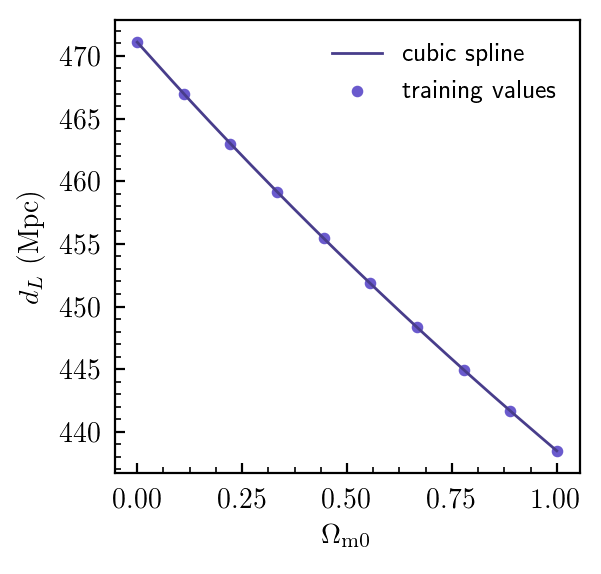

In [151]:
plot_line_points(om0test, dl_spline, xp=om0train, yp=dltrain, points=True, psize=40, 
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', 
                 legend='cubic spline', plegend='training values',
                 legendloc='upper right', figsize=3)

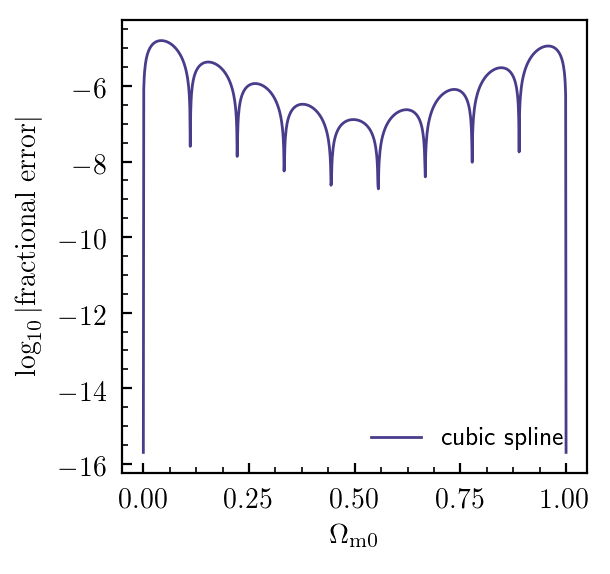

In [152]:
plot_line_points(om0test, np.log10(np.maximum(2.e-16,np.abs(1.-dl_spline/dltest))), 
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\log_{10}\vert\rm fractional\ error\vert$', 
                 legend='cubic spline', plegend='training values',
                 legendloc='lower right', figsize=3)

So this implementation of spline interpolation results in $\sim 10^{-6}$ fractional errors for 10 training points. 

Below in helper <tt>poly_fit_func</tt> we use scipy and numpy functions for different polynomial regression and interpolation, as well as spline using <tt>scipy.interpolate.interp1d</tt> and compute and plot fractional error of the polynomial interpolation on evenly spaced training points, Chebyshev points, and cubic piecewise spline approximation. 

Chebyshev training point placement is introduced and discussed in <a href="https://drive.google.com/file/d/1Pr_Eg9Ieg8Ex6Lv0OnlBfkF6EiLJBUEB/view?usp=sharing">05_approximation</a> notebook. 

Barycentric interpolation method used for the polynomial interpolation in the function below is also described in that notebook in the material for graduate students. 

### <font color='darkblue'>Experiment: testing fractional accuracy of polynomial and spline approximation for the $d_L$ function.  


In [154]:
from scipy.interpolate import interp1d
from scipy.interpolate import barycentric_interpolate

def poly_fit_func(xtrain, ytrain, xtest, method='poly', porder=None, sporder=3):
    if method == 'pwlin': # piecewise linear approximation
        return np.interp(xtest, xtrain, ytrain)
    elif method == 'poly': # polynomial approximation
        ntrain = np.size(ytrain)
        if porder is None: # if polynomial order is not supplied, assume we are interpolating
            porder = ntrain
        assert(porder <= ntrain)
        if porder == ntrain: 
            return barycentric_interpolate(xtrain, ytrain, xtest)
        else:
            polyfit = np.polyfit(xtrain, ytrain, porder)
            pfit = np.poly1d(polyfit)
            return pfit(xtest)
    elif method == 'spline': # spline interpolation, default is cubic sporder=3
        spl = interp1d(xtrain, ytrain, kind=sporder, fill_value="extrapolate")
        return spl(xtest)

In [155]:
# functions generating N+1 Chebyshev nodes of the 1st and 2nd kind 
# for input N, and interval edges a and b

def chebyshev_nodes1(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos((2.*np.arange(N+1)+1)*np.pi/(2.*(N+1))))

def chebyshev_nodes2(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos(np.arange(N+1)*np.pi/N))

In [156]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, Om0, OmL):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    return cosmo.luminosity_distance(z=z) / u.Mpc

In [162]:
from scipy.interpolate import interp1d

def poly_fit_func(xtrain, ytrain, xtest, method='poly', porder=None, sporder=3):
    """A helper function to perform polynomial and spline interpolation and regression
    
    """
    if method == 'pwlin': # piecewise linear approximation
        return np.interp(xtest, xtrain, ytrain)
    
    elif method == 'poly': # polynomial interpolation or regression
        ntrain = np.size(ytrain)
        if porder is None: # if polynomial order is not supplied, assume we are interpolating
            porder = ntrain
        assert(porder <= ntrain) # make sure that order is smaller than the size of the training sample
        polyfit = np.polyfit(xtrain, ytrain, porder) # compute polynomial coefficients by solving system of normal equations
        pfit = np.poly1d(polyfit) # initialize 1d polynomial class with these coefficients
        return pfit(xtest)[::-1] # return polynomial values at test points
    elif method == 'spline': # spline interpolation, default is cubic sporder=3
        spl = interp1d(xtrain, ytrain, kind=sporder, fill_value="extrapolate")
        return spl(xtest)[::-1]    

In [158]:
def compute_dl_train(om0train, om0test, z=0.1, H0=70., oml=0.7):
    """
    compute d_l using Astropy function for input training points (om0train) and test points (om0test)
    
    Parameters: om0train and om0test - float numpy arrays
    Returns: float numpy vectors dltrain, dltest, dlpoly (polynomial approximation at test points)
            corresponding to om0train, om0test values 
    """

    # evaluate d_L at training points
    dltrain = np.empty_like(om0train)
    for i, omd in enumerate(om0train):
        dltrain[i] = d_l_astropy(z, H0, omd, 1.-omd)

    # evaluate d_L at test points
    dltest = np.empty_like(om0test)
    for i, omd in enumerate(om0test):
        dltest[i] = d_l_astropy(z, H0, omd, 1.-omd)
        
    # compute polynomial approximation at test points 
    dlpoly = poly_fit_func(om0train, dltrain, om0test)
    
    return dltrain, dltest[::-1], dlpoly

In [159]:
ntrain, ntest = 10, 1000 # number of the training set and test points
om0min, om0max = 0., 1.
# test points will be the same for all schemes
om0test = np.linspace(om0min, om0max, ntest+1)

# evenly spaced training points
om0train_e = np.linspace(om0min, om0max, ntrain)
dltrain_e, dltest_e, dlpoly_e = compute_dl_train(om0train_e, om0test) 

# Chebyshev nodes of the 1st kind 
om0train_c1 = chebyshev_nodes1(om0min, om0max, ntrain)
dltrain_c1, dltest_c1, dlpoly_c1 = compute_dl_train(om0train_c1, om0test) 

# cubic spline
dl_spline = poly_fit_func(om0train_e, dltrain_e, om0test, method='spline')

C:\Users\h2_sf\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
C:\Users\h2_sf\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


In [160]:
# fractional error of the polynomial approximation for evenly spaced training points
frac_err_poly_e   = np.log10(np.maximum(np.abs(1.0 - dlpoly_e/dltest_e), 2.e-16))
# fractional error of the polynomial approximation for Chebyshev 1 training points
frac_err_poly_c1  = np.log10(np.maximum(np.abs(1.0 - dlpoly_c1/dltest_c1), 2.e-16))
# fractional error of the spline approximation for Chebyshev 2 training points
frac_err_s = np.log10(np.maximum(np.abs(1.0 - dl_spline/dltest_e), 2.e-16))

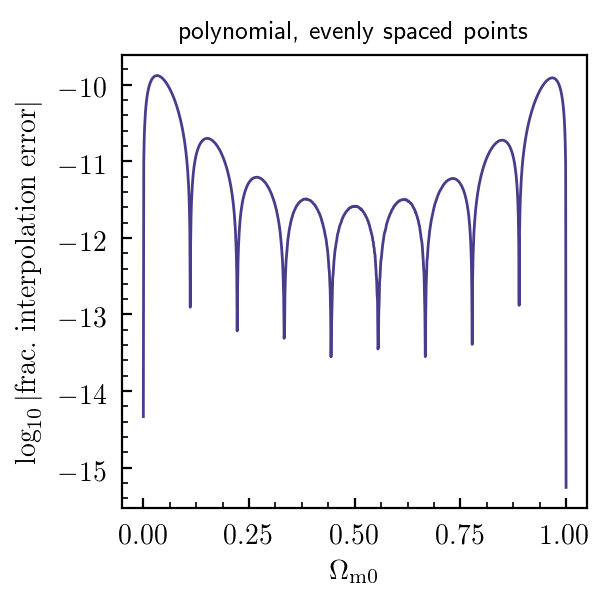

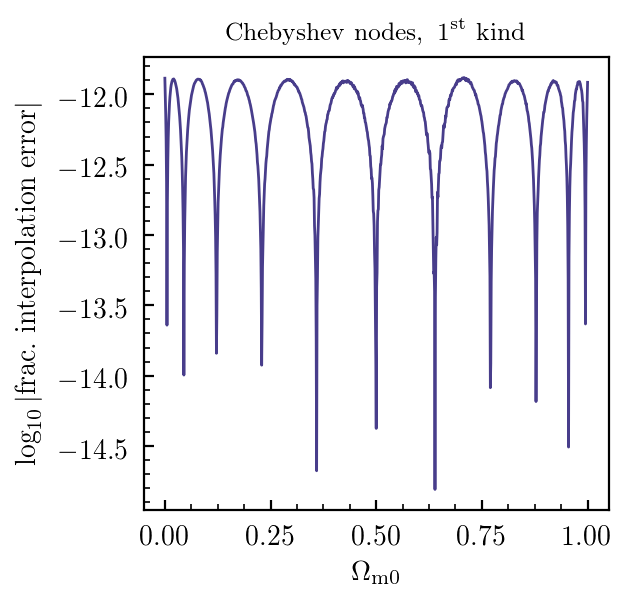

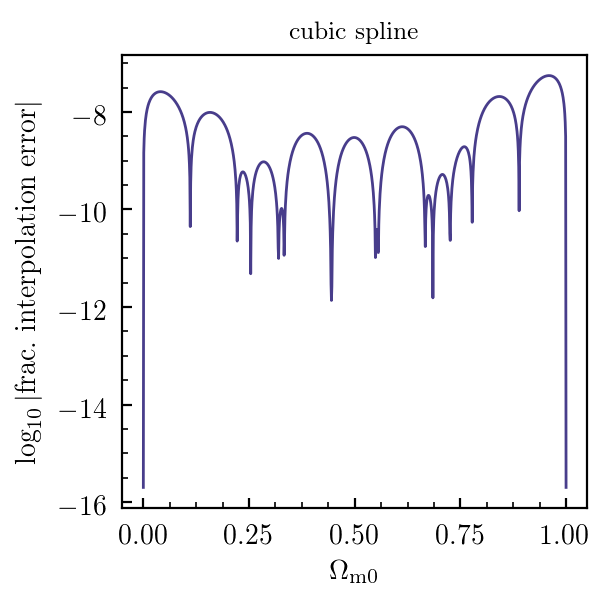

In [161]:
plot_line_points(om0test, frac_err_poly_e,
                 xlabel=r'$\Omega_{\rm m0}$', 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', 
                 plot_title='polynomial, evenly spaced points', figsize=3)

plot_line_points(om0test, frac_err_poly_c1,
                 xlabel=r'$\Omega_{\rm m0}$', 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', 
                 plot_title=r'$\rm Chebyshev\ nodes,\ 1^{st}\ kind$', figsize=3)

plot_line_points(om0test, frac_err_s,
                 xlabel=r'$\Omega_{\rm m0}$', points = False, 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', 
                 plot_title=r'$\rm cubic\ spline$', 
                 figsize=3)

For <tt>ntrain=10</tt> Chebyshev and even-spaced trainig point polynomial interpolation provides superior accuracy compared to splines. However, spline interpolation will never run into numerical issues as the number of training point increases. 

If you compare fractional accuracy of the scipy's spline function in the plot above to the previous experiment, where my own spline function was used, you can notice that the latter produced less accurate results. This is likely because coefficients in this case are computed less efficiently (more computations than in the more efficient B-spline basis used in scipy's function). 

Experiment with the number of training points <tt>ntrain</tt> above and examine how accuracy of approximation changes. 

### <font color='darkblue'>Using splines to numerically invert monotonic functions

The interpolating spline can be used to effectively invert a complicated function or find its root(s). 
    
    
If we construct a spline, $s(f)$, for $x(f)$, we can use it to find $x$ for any $f$ value within the original interpolated range or find root(s) by querying $s(0)$. This works for functions $f$ that are monotonic on interpolation interval, because spline construction algoithm  assumes that the independent variable used in spline is arranged in the ascending order. 
    
    
Thus, before constructing the spline $\{f_i\}$ and $\{x_i\}$ values that are "splined" should be 
sorted in such a way that the former are in ascending order. If $f$ is not monotonic, we can still do this if we split the relevant interval into ranges within which $f$ is monotonic. 
    
The use of splines for integrating and inverting functions makes them an extremely useful and powerful tool in a wide variety of calculations. 

### <font color='darkblue'>A few examples of applications of spline approximations in astronomy
    
Generally, spline provide smooth approximations for functions and their first derivatives and thus are applied whenever it is reasonable to assume that approximated functions are smooth.  Examples of use of the $B$-splines in astronomical image analyses and data reduction include analyses of spectra (<a href="https://ui.adsabs.harvard.edu/abs/1994ApJ...436..787A">Akerlof et al. 1994</a>, <a href="https://ui.adsabs.harvard.edu/abs/2009PASP..121.1409B/abstract">Bochanski et al. 2009</a>), modelling surface brightness distribution of light in galaxies (<a href="https://ui.adsabs.harvard.edu/abs/2006ApJ...638..703B/abstract">Bolton et al. 2006</a>), modelling sky emission for background subtraction (<a href="https://ui.adsabs.harvard.edu/abs/2003PASP..115..688K/abstract">Kelson 2003</a>), approximation for ``flat fields'' for images and spectra (Bolton & Burles 2007). 


Many astronomers, your instructor included, use splines daily in their research for function approximation and inversion. 

### <font color='darkblue'>Practical recommendations for the polynomial approximation

* Spline interpolation is the method of choice for interpolation of generic smooth and even many non-smooth functions.  
    

* Do not use global polynomial approximation for orders $N\gtrsim 30-50$ (or even smaller), unless 
you can choose the training points at which the function is tabulated. 
    

* If you can use the training points, use can use Chebyshev nodes and Chebyshev polynomial interpolation that is accurate
and can be carried out in $\mathcal{O}(N)$ operation for interpolation of $N+1$ nodes. However, for some functions spline interpolation may still be more accurate. 


* Global polynomial interpolation for evenly spaced tabulated points is to be avoided for $N\gtrsim 4-5$, due to ubiquitous spurious oscillations of the interpolating polynomial
    (Runge oscillations; see <tt>08b_polynomial_approximation_chebyshev</tt> notebook). These oscillations tend to be largest near the edges of the interval on which function is tabulated and only grow with increasing polynomial
order. Large or discontinuous derivatives in the approximated function $f(x)$ cause largest interpolation errors when are located near the center of approximation interval. 


* Functions with discontinuities, such as the square (tophat) pulse, will produce spurious oscillations in both piecewise and global polynomial approximations near discontinuities (the Gibbs phenomenon). These oscillations do not decrease with increasing $N$, but only get confined closer to the discontinuity. The approximation thus does not converge to the real
function with increasing $N$. In such cases, piecewise polynomial constructed using an essentially non-oscillatory (ENO) scheme can be used instead either everywhere or near discontinuity only. 

    
* Polynomial approximation is also not efficient when $f(x)$ has vertical or horizontal asymptotes. 

    
* ***Do not extrapolate unless you are absolutely certain in how function should behave outside approximated interval!***
Regardless of the accuracy of approximation within the interval where function is tabulated, the approximation error can grow exponentially outside the tabulated interval. Extrapolation should therefore be avoided, unless it can be done in a way well informed by the known asymptotic behavior of the approximated function or physical intuition about such behavior. 


### <font color='darkblue'>Linear system of equations for spline coefficients
---------------------------------
***This is a technical info on derivation of the equations for spline coefficients. You can skip it, unless you are curious about how splines are constructed in detail.***

---------------------------------

For a set of $N$ cubic splines defined for $N+1$ interpolation points $\{x_i\}$ and corresponding function values $f_i$:

$$
s_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3,
$$

with $4N$ constraints discussed above, we can compute $4N$ coefficients $\{a_i,b_i,c_i,d_i\}$. 
Derivation presented here uses *natural spline* edge constraints. Similar systems of equations are derived for other types of splines. 

Spline constraint $s^{\prime\prime}_i(x_{i+1})=s^{\prime\prime}_{i+1}(x_{i+1})$ results in equation
$$
s^{\prime\prime}_i(x_{i+1})-s^{\prime\prime}_{i+1}(x_{i+1})=0= 2(c_i-c_{i+1} )+6d_i\delta_i,\ \ \ \rightarrow d_i = \frac{c_{i+1}-c_i}{3\delta_i},\ \ \ (1)
$$
where $\delta_i=x_{i+1}-x_i$. 

Condition $s_i(x_{i+1})=s_{i+1}(x_{i+1})$ gives

$$
f_i+b_i \delta_i+c_i\delta_i^2 + d_i \delta_i^3 = f_{i+1},
$$

which gives (denoting $\Delta_i=f_{i+1}-f_i$)

$$
 b_i=\frac{\Delta_i}{\delta_i} - c_i\delta_i - d_i\delta_i^2=\frac{\Delta_i}{\delta_i} - (c_{i+1}+2c_i)\frac{\delta_i}{3},\ \ \ \ (2)
$$

where  equation 1 was used for $d_i$. 

The third spline condition, $s^\prime_i(x_{i+1})=s^\prime_{i+1}(x_{i+1})$, gives equations: 
$$
s^\prime_i(x_{i+1})-s^\prime_{i+1}(x_{i+1}) = 0 = b_i-b_{i+1} + 2c_i\delta_i + 3d_i\delta_i^2.
$$

Substituting eqsuations 1 and 2 into this equation, after a bit of algebra we can get: 
$$
\delta_i c_i + 2(\delta_i+\delta_{i+1})\,c_{i+1} + \delta_{i+1}c_{i+2} = 3\left(\frac{\Delta_{i+1}}{\delta_{i+1}}-\frac{\Delta_i}{\delta_i}\right),\ \ \ \ i=0,\dots, N-2.
$$

Given that $c_{i+2}$ is needed in this equation, it can only be defined for the first $N-1$ intervals and for the $(N-1)$-th interval $c_{i+2}=c_{N-1}=s^{\prime\prime}_{N-1}(x_N)/2$. 

For natual splines $s^{\prime\prime}_{0}(x_0)=s^{\prime\prime}_{N-1}(x_N) = 0$, i.e. $c_0=c_{N-1}=0$, which provide 2 additional equations to derive $N$ constants $\{c_i\}$, $i=0,\dots, N-1$. The system of linear equations for $c_i$ can be 
written in matrix form: 
\begin{equation}
\begin{bmatrix} 
1 & 0 & 0 & \cdots &  & & \\
\delta_0 & 2(\delta_0+\delta_1) & \delta_1 & \ddots & & & \\
0             &  \delta_1  & 2(\delta_1+\delta_2) & \delta_2 & \ddots & & \\
    & \ddots & \ddots & \ddots & \ddots & & \\
              &            &             &             &\delta_{N-2} &2(\delta_{N-2}+\delta_{N-1}) &\delta_{N-1} \\
              &            &             &             & 0  & 0 & 1
\end{bmatrix}
\left[ \begin{array}{c} c_0\\ c_1\\ \vdots\\ \vdots\\ \vdots \\ c_{N-1} \end{array} \right] 
=
\left[ \begin{array}{c} 0\\ 3\left(\frac{\Delta_1}{\delta_1}-\frac{\Delta_0}{\delta_0}\right)\\ \vdots\\ \vdots\\  
3\left(\frac{\Delta_{N-1}}{\delta_{N-1}}-\frac{\Delta_{N-2}}{\delta_{N-2}}\right)\\ 0 \end{array} \right] 
\end{equation}

Note that constraints mostly relate neighboring three intervals. This is why the left matrix is tridiagonal and such matrix equation can be solved efficiently using the <a href="https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)">Thomas method</a>. This method solves such system of equations in $\sim \mathcal{O}(N)$ operations. 

Once $\{c_i\}$ are obtained as a solution of the above matrix equation,  $\{b_i\}$ and  $\{d_i\}$ coefficients can be computed   
using equations 2 and 1.
    
These equations are used in the function for spline interpolation provided in this notebook. In practice, spline interpolation in library functions is usually done with more efficient $B$-spline functional basis, but the logic is similar. 